In [1]:
import glob
import os
masks = sorted(glob.glob("../data/Dataset/damage_mask/Scratched_train_mask/*.png"), key=os.path.basename)
orgs = sorted(glob.glob("../data/Dataset/damage_type/Scratched_img_train/*.jpg"), key=os.path.basename)

In [2]:
print(len(masks))

47751


In [3]:
%%time

import numpy as np
import sys
from tqdm import tqdm
from PIL import Image
import cv2
# np.set_printoptions(threshold=sys.maxsize)

t_lim = 11937
imgs_list2 = np.zeros((len(orgs),128,128,3), dtype=np.uint8)
count = 0;
# imgs_list = []
masks_list = []
for image, mask in zip(tqdm(orgs), masks):

    try:
        if np.array(Image.open(image).resize((128, 128))).shape == (128,128,4):
            temp = np.delete(np.array(Image.open(image).resize((128, 128))), 3, axis=2)
            imgs_list2[count] = temp
        else:
            imgs_list2[count] = np.array(Image.open(image).resize((128, 128)))
    except ValueError:
        print("Error at", count, ValueError)
        break


    im = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    im = cv2.resize(im, (128,128))
    im = np.expand_dims(im, axis=-1)
    masks_list.append(im) 
    count += 1

    
imgs_np = imgs_list2
masks_np = np.array(masks_list)

100%|█████████████████████████████████████| 47751/47751 [14:38<00:00, 54.38it/s]


CPU times: user 14min 33s, sys: 8.75 s, total: 14min 41s
Wall time: 14min 38s


In [2]:
print(masks_np.shape)

NameError: name 'masks_np' is not defined

2023-01-23 06:10:38.958139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 06:10:39.875644: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hyuna3589/.local/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.8/lib64:
2023-01-23 06:10:39.875771: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hyuna3589/.local/lib/python3

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

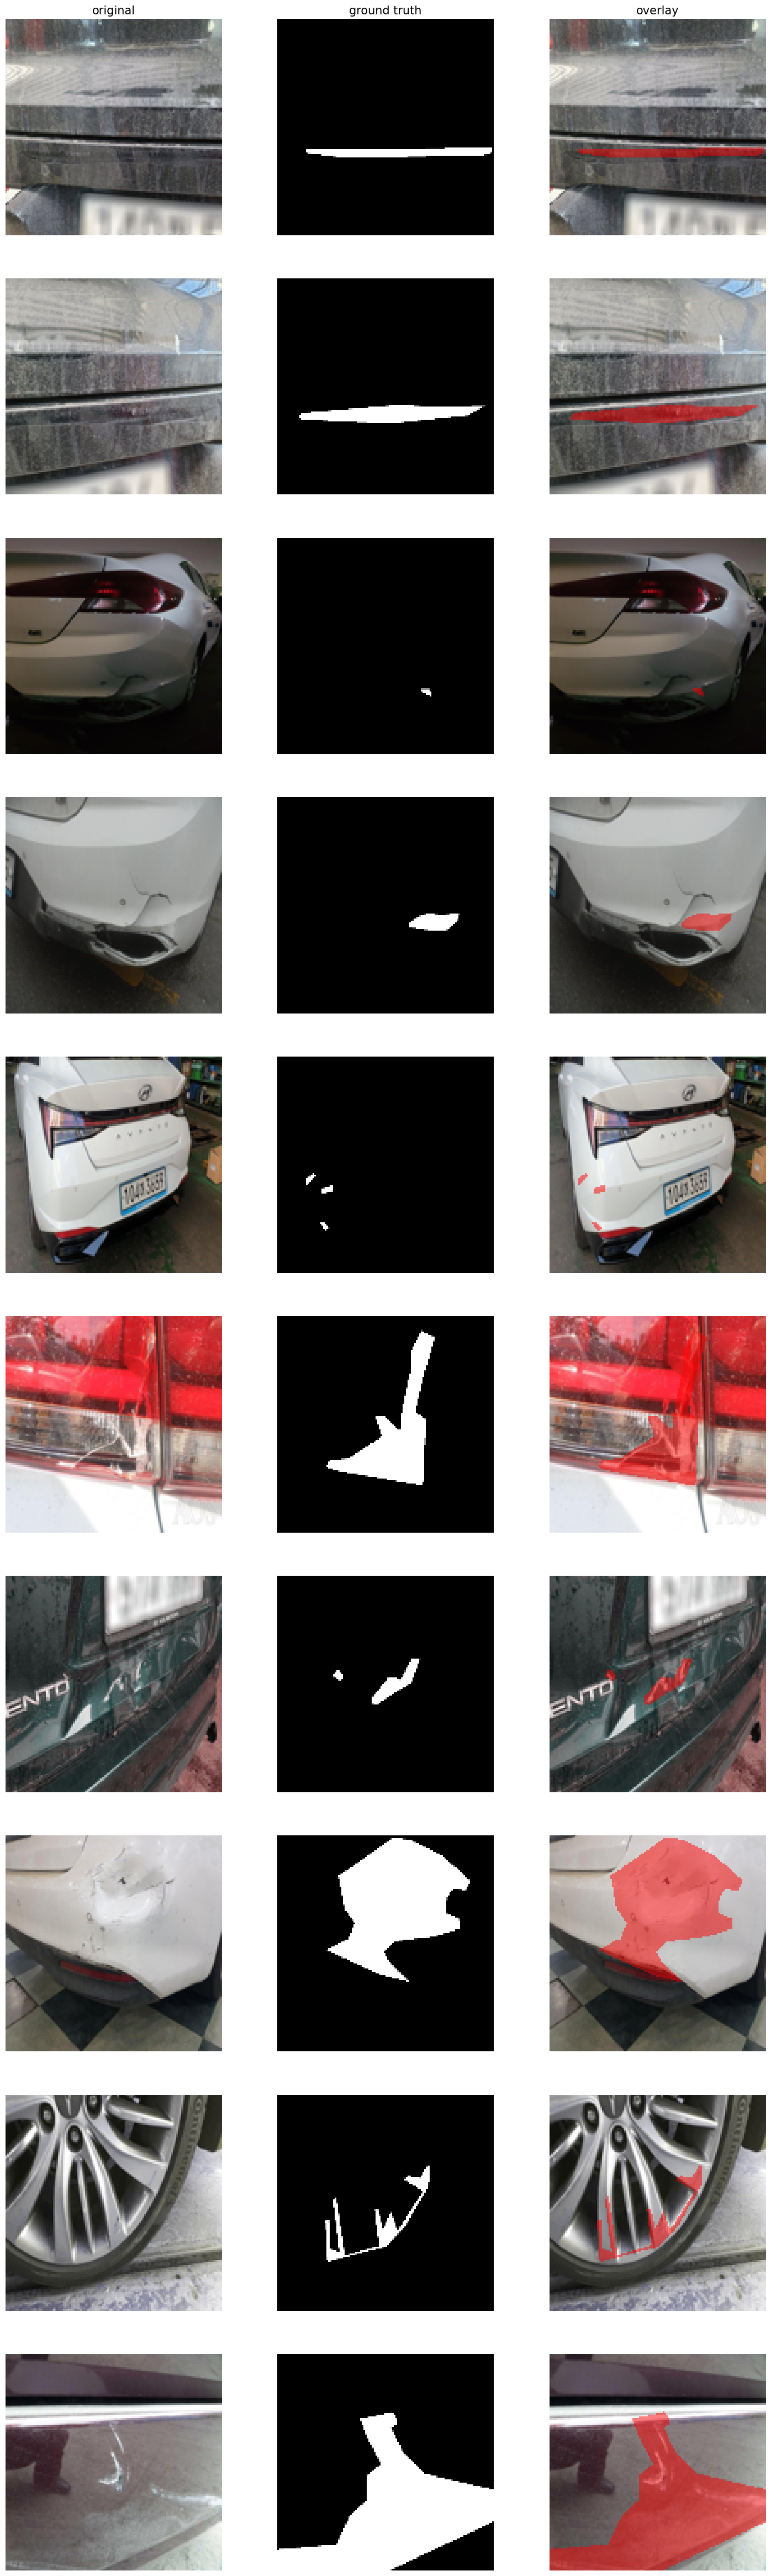

CPU times: user 3.56 s, sys: 908 ms, total: 4.46 s
Wall time: 3.6 s


In [5]:
%%time

from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=imgs_np, mask_imgs=masks_np, nm_img_to_plot=10, figsize=6)

In [6]:
print(imgs_np.max(), masks_np.max())

255 79


In [7]:
x = np.asarray(imgs_np, dtype=np.float32)/255
y = np.asarray(masks_np, dtype=np.float32)/255

In [8]:
print(x.max(), y.max())

1.0 0.30980393


In [9]:
print(x.shape, y.shape)

(47751, 128, 128, 3) (47751, 128, 128, 1)


In [10]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.5, random_state=0)

print("x_train :", x_train.shape)
print("y_train :", y_train.shape)
print("x_val :", x_val.shape)
print("y_val :", y_val.shape)

x_train : (23875, 128, 128, 3)
y_train : (23875, 128, 128, 1)
x_val : (23876, 128, 128, 3)
y_val : (23876, 128, 128, 1)


In [11]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args=dict(
        rotation_range=15,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

(2, 128, 128, 3) (2, 128, 128, 1)


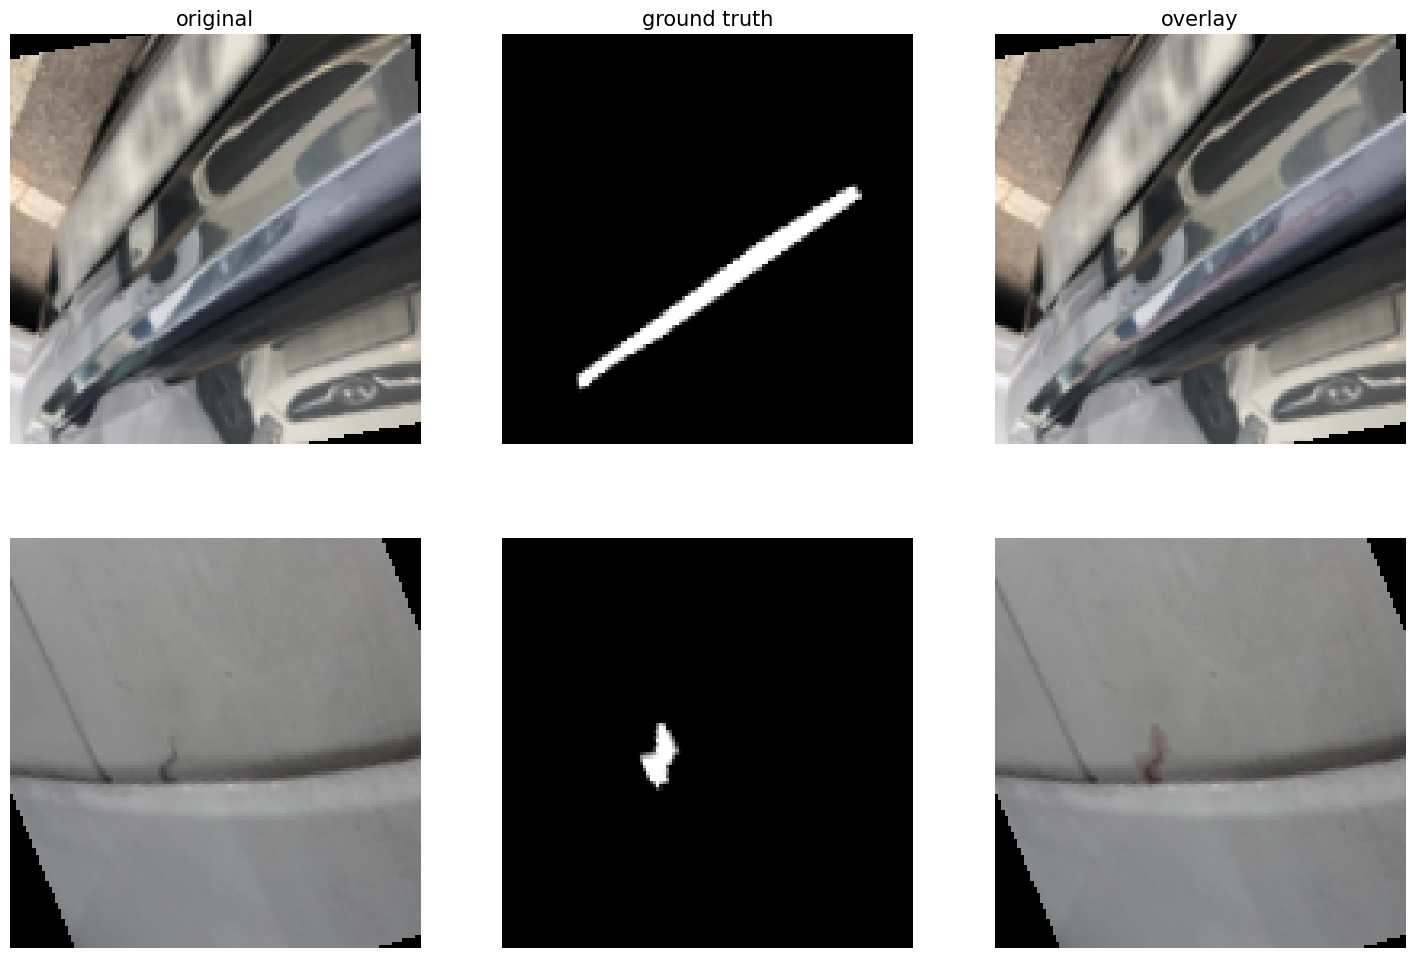

In [12]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)

from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [13]:
from keras_unet.models import custom_unet

input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

2023-01-23 06:13:38.446692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 06:13:38.819567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 06:13:38.819877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 06:13:38.824692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [14]:
from keras.callbacks import ModelCheckpoint

model_filename = 'segm_model_scratch.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename,
    verbose=1,
    monitor='val_loss',
    save_best_only=True,
)

In [15]:
from tensorflow.keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [16]:
history=model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=100,

    validation_data=(x_val,y_val),
    callbacks=[callback_checkpoint]
)

Epoch 1/100


/tmp/ipykernel_4512/3335996054.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(
2023-01-23 06:14:15.907710: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/spatial_dropout2d/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-01-23 06:14:18.653796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-01-23 06:14:22.502636: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x559220729b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-23 06:14:22.502683: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2023-01-23 06:14:22.875462: I tensorflow/compiler/jit/xla

100/100 [==============================] - ETA: 0s - loss: 0.1618 - iou: 0.0080 - iou_thresholded: 0.0048

2023-01-23 06:14:26.847577: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4694212608 exceeds 10% of free system memory.
2023-01-23 06:14:33.493549: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 4694212608 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 0.09295, saving model to segm_model_scratch.h5
100/100 [==============================] - 52s 413ms/step - loss: 0.1618 - iou: 0.0080 - iou_thresholded: 0.0048 - val_loss: 0.0930 - val_iou: 0.0122 - val_iou_thresholded: 1.1289e-04
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.0985 - iou: 0.0115 - iou_thresholded: 0.0045
Epoch 2: val_loss did not improve from 0.09295
100/100 [==============================] - 27s 272ms/step - loss: 0.0985 - iou: 0.0115 - iou_thresholded: 0.0045 - val_loss: 0.0977 - val_iou: 0.0129 - val_iou_thresholded: 1.1289e-04
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.1044 - iou: 0.0120 - iou_thresholded: 0.0035
Epoch 3: val_loss improved from 0.09295 to 0.09236, saving model to segm_model_scratch.h5
100/100 [==============================] - 29s 288ms/step - loss: 0.1044 - iou: 0.0120 - iou_thresholded: 0.0035 - val_loss: 0.0924 - val_iou: 0.0116 - val_iou_thresholded:

100/100 [==============================] - 27s 272ms/step - loss: 0.0943 - iou: 0.0116 - iou_thresholded: 0.0046 - val_loss: 0.0912 - val_iou: 0.0110 - val_iou_thresholded: 1.1289e-04
Epoch 48/100
100/100 [==============================] - ETA: 0s - loss: 0.0796 - iou: 0.0097 - iou_thresholded: 0.0058
Epoch 48: val_loss improved from 0.09078 to 0.09039, saving model to segm_model_scratch.h5
100/100 [==============================] - 29s 288ms/step - loss: 0.0796 - iou: 0.0097 - iou_thresholded: 0.0058 - val_loss: 0.0904 - val_iou: 0.0098 - val_iou_thresholded: 1.1289e-04
Epoch 49/100
100/100 [==============================] - ETA: 0s - loss: 0.1028 - iou: 0.0129 - iou_thresholded: 0.0040
Epoch 49: val_loss did not improve from 0.09039
100/100 [==============================] - 27s 272ms/step - loss: 0.1028 - iou: 0.0129 - iou_thresholded: 0.0040 - val_loss: 0.0931 - val_iou: 0.0121 - val_iou_thresholded: 1.1289e-04
Epoch 50/100
100/100 [==============================] - ETA: 0s - loss:

100/100 [==============================] - 27s 272ms/step - loss: 0.0882 - iou: 0.0117 - iou_thresholded: 0.0042 - val_loss: 0.0901 - val_iou: 0.0105 - val_iou_thresholded: 1.1289e-04
Epoch 71/100
100/100 [==============================] - ETA: 0s - loss: 0.1033 - iou: 0.0115 - iou_thresholded: 0.0057
Epoch 71: val_loss did not improve from 0.09002
100/100 [==============================] - 27s 271ms/step - loss: 0.1033 - iou: 0.0115 - iou_thresholded: 0.0057 - val_loss: 0.0938 - val_iou: 0.0122 - val_iou_thresholded: 1.1289e-04
Epoch 72/100
100/100 [==============================] - ETA: 0s - loss: 0.0915 - iou: 0.0124 - iou_thresholded: 0.0037
Epoch 72: val_loss did not improve from 0.09002
100/100 [==============================] - 27s 272ms/step - loss: 0.0915 - iou: 0.0124 - iou_thresholded: 0.0037 - val_loss: 0.0908 - val_iou: 0.0109 - val_iou_thresholded: 1.1289e-04
Epoch 73/100
100/100 [==============================] - ETA: 0s - loss: 0.0847 - iou: 0.0104 - iou_thresholded: 0.

In [17]:
import glob
tests = glob.glob("../data/Dataset/damage_type/Scratched_img_test/*.jpg")

In [18]:
import numpy as np
from PIL import Image
import cv2

tests_list=[]
for test in tests:
    test_img = cv2.imread(test)
    # print(im.shape)
    test_img = cv2.resize(test_img, (128,128))
    # print(im.shape)

    #print(im.shape)
    tests_list.append(test_img)

tests_np = np.asarray(tests_list)

In [19]:
tests_np.shape

(5975, 128, 128, 3)

In [21]:
model.load_weights('segm_model_scratch.h5')

test_preds = model.predict(tests_np)
# test_preds

187/187 [==============================] - 7s 35ms/step


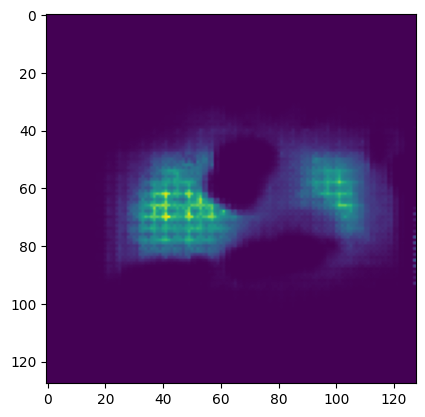

In [25]:
import matplotlib.pyplot as plt

plt.imshow(test_preds[0])


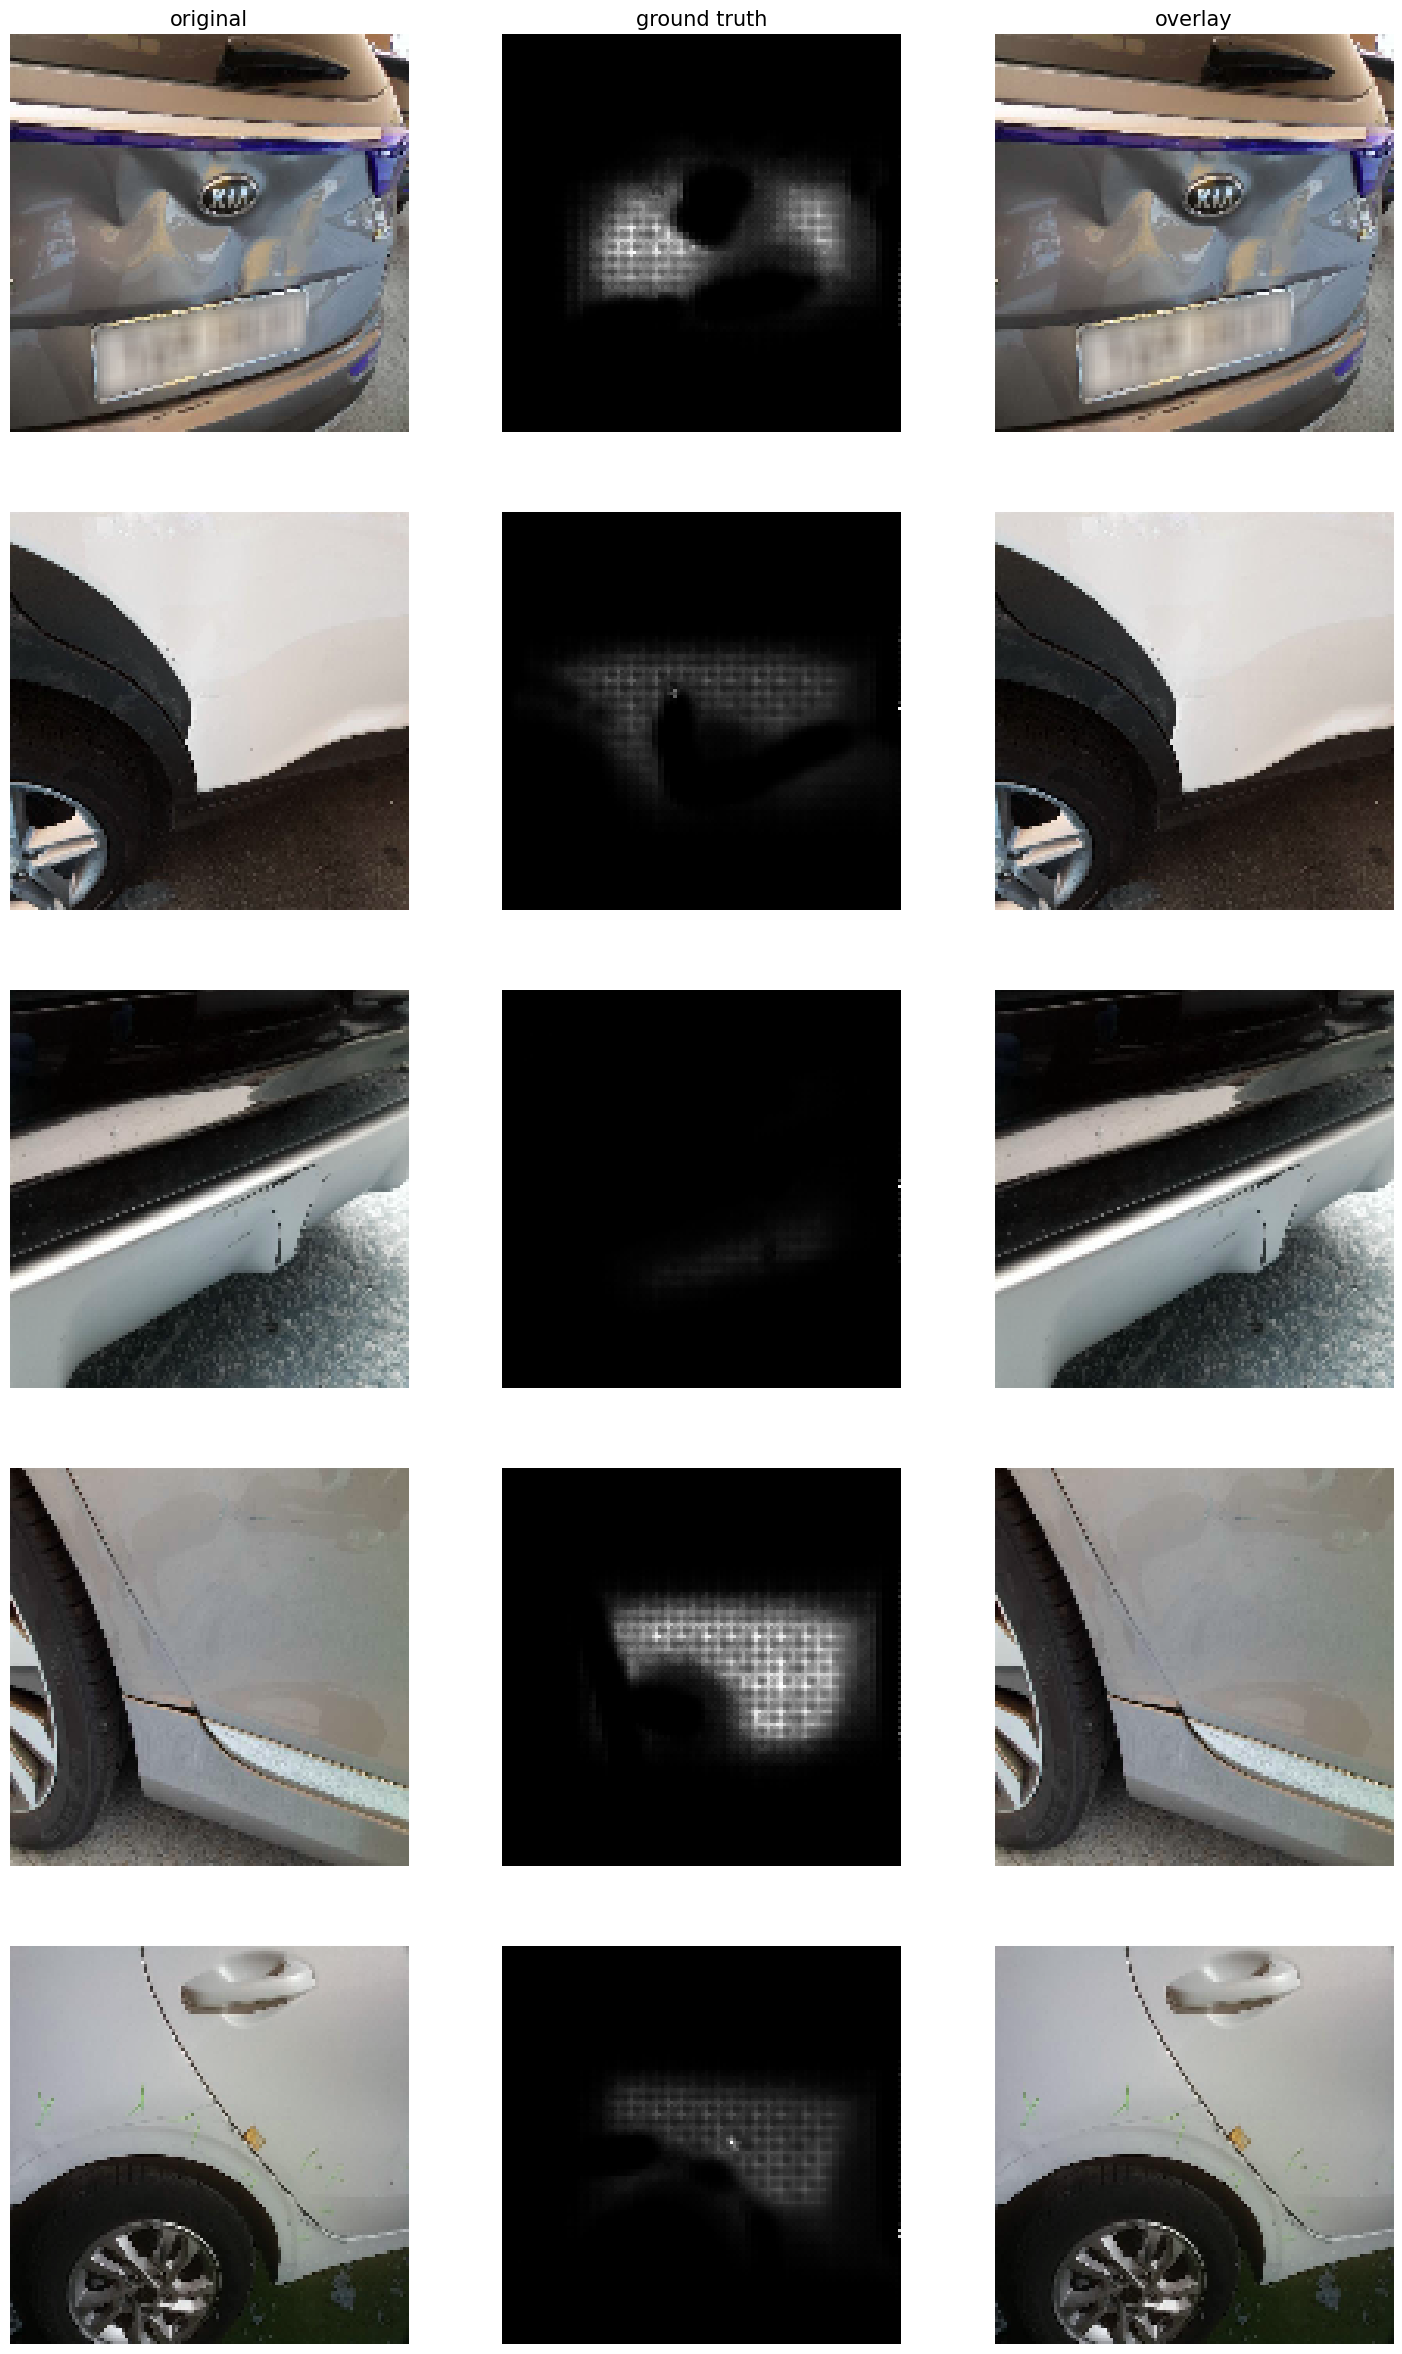

In [23]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=tests_np, mask_imgs=test_preds, nm_img_to_plot=5, figsize=6)

In [6]:
!pip install keras-unet

Defaulting to user installation because normal site-packages is not writeable


In [15]:
#!pip install matplotlib
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install --upgrade pip setuptools wheel

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.4 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
!pip install keras-unet

Defaulting to user installation because normal site-packages is not writeable
